In [30]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import cv2
import shutil
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
 
from keras.layers import Dropout, Flatten, Activation, Dense, GlobalMaxPooling2D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from keras.callbacks import CSVLogger
from keras.utils.vis_utils import plot_model

In [2]:
# Define Global Hyperparameters

IMAGE_SIZE = 96
EPOCHS = 10
BATCH_SIZE = 256
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [3]:
input_dir = "./data/"
train_dir = input_dir + str("train/")
val_dir = input_dir + str("val/")
test_dir = input_dir + str("test/")

In [4]:
df = pd.read_csv("./data/train_labels.csv")
df['path'] = [str(train_dir)+str(x)+".tif" for x in df['id']]
df['image'] = [cv2.imread(x) for x in df['path']]

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.033)

neg_train_samples = train_df[train_df.label == 0]
pos_train_samples = train_df[train_df.label == 1]

neg_val_samples = val_df[val_df.label == 0]
pos_val_samples = val_df[val_df.label == 1]

neg_train_samples = neg_train_samples.reset_index(drop=True)
pos_train_samples = pos_train_samples.reset_index(drop=True)

neg_val_samples = neg_val_samples.reset_index(drop=True)
pos_val_samples = pos_val_samples.reset_index(drop=True)


print("# Of Negative Training Samples : {}".format(len(neg_train_samples)))
print("# Of Positive Training Samples : {}".format(len(pos_train_samples)))
print("# Of Negative Validation Samples : {}".format(len(neg_val_samples)))
print("# Of Positive Validation Samples : {}".format(len(pos_val_samples)))

In [ ]:
# Code here to move images into the appropriate directories as they start sitting in the train and test folders
# and need to be moved into train/0, train/1 and test/0, test/1

#[shutil.move(x, train_dir + "0/") for x in neg_train_samples['path']]
#[shutil.move(x, train_dir + "1/") for x in pos_train_samples['path']]
#[shutil.move(x, val_dir + "0/") for x in neg_val_samples['path']]
#[shutil.move(x, val_dir + "1/") for x in pos_val_samples['path']]

#for filename in os.listdir("./data/train/0/"):
#    if filename.endswith(".tif"):
#        shutil.move("./data/train/0/"+filename, train_dir)
#
#for filename in os.listdir("./data/train/1/"):
#    if filename.endswith(".tif"):
#        shutil.move("./data/train/1/"+filename, train_dir)

In [5]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.3, 
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [8]:
# Data augmentation
val_data_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Data generation
training_generator = training_data_generator.flow_from_directory(train_dir,
                                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                 batch_size=BATCH_SIZE,
                                                                 class_mode='binary')

Found 212764 images belonging to 2 classes.


In [10]:
validation_generator = val_data_generator.flow_from_directory(val_dir,
                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='binary')

Found 7261 images belonging to 2 classes.


In [14]:
# Model Ver. 1.0 - model_V_1

# Define what the input will look like
image_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Define the VGG16 model to use the imagenet weights without a top (note the input shape as image_shape)
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(image_shape))


# Create the model
model_V_1 = Sequential()
 
# Add the vgg convolutional base model
model_V_1.add(vgg_conv)
 
# Add new layers
model_V_1.add(Flatten())
model_V_1.add(Dense(512, activation='relu'))
model_V_1.add(Dropout(0.4))
model_V_1.add(Dense(1, activation='sigmoid'))
 
# Show a summary of the model. Check the number of trainable parameters
model_V_1.summary()

model_V_1.compile(optimizer=Adam(lr=0.0002, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 17,075,009
Trainable params: 17,075,009
Non-trainable params: 0
_________________________________________________________________


In [19]:
#  Training
history_V_1 = model_V_1.fit_generator(training_generator,
                                      steps_per_epoch=len(training_generator), 
                                      validation_data=validation_generator,
                                      validation_steps=len(validation_generator),
                                      epochs=EPOCHS,
                                      verbose=VERBOSITY)

Epoch 1/10
832/832 [==============================] - 617s 742ms/step - loss: 0.3334 - acc: 0.8552 - val_loss: 0.2211 - val_acc: 0.9167
Epoch 2/10
832/832 [==============================] - 613s 737ms/step - loss: 0.2245 - acc: 0.9121 - val_loss: 0.1894 - val_acc: 0.9291
Epoch 3/10
832/832 [==============================] - 615s 739ms/step - loss: 0.1986 - acc: 0.9234 - val_loss: 0.1611 - val_acc: 0.9426
Epoch 4/10
832/832 [==============================] - 619s 744ms/step - loss: 0.1869 - acc: 0.9297 - val_loss: 0.2212 - val_acc: 0.9198
Epoch 5/10
832/832 [==============================] - 616s 741ms/step - loss: 0.1736 - acc: 0.9351 - val_loss: 0.1655 - val_acc: 0.9402
Epoch 6/10
832/832 [==============================] - 616s 740ms/step - loss: 0.1653 - acc: 0.9388 - val_loss: 0.1443 - val_acc: 0.9470
Epoch 7/10
832/832 [==============================] - 616s 741ms/step - loss: 0.1615 - acc: 0.9403 - val_loss: 0.1905 - val_acc: 0.9303
Epoch 8/10
832/832 [============================

Text(0.5,0,'epoch')

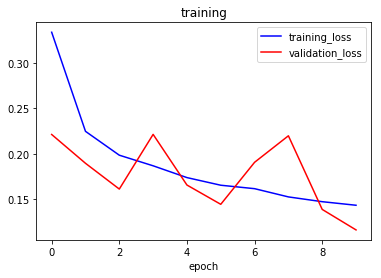

In [23]:
plt.plot(history_V_1.history['loss'], color='blue', label="training_loss")
plt.plot(history_V_1.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

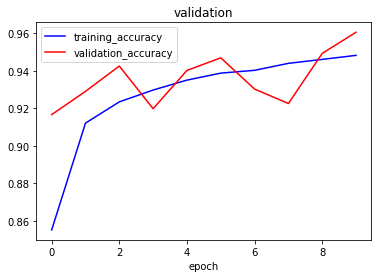

In [26]:
plt.plot(history_V_1.history['acc'], color='blue', label="training_accuracy")
plt.plot(history_V_1.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')

29/29 [==============================] - 4s 121ms/step


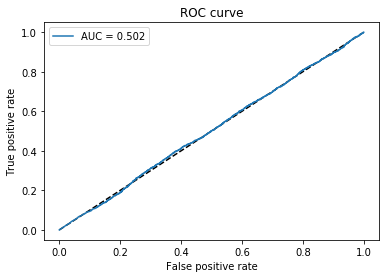

In [31]:
# ROC testing plot
predictions = model_V_1.predict_generator(validation_generator, steps=len(validation_generator), verbose=VERBOSITY)
false_positive_rate, true_positive_rate, threshold = roc_curve(validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')